# Variational Auto-encoder

This notebook presents a variational auto-encoder ([paper](https://arxiv.org/abs/1312.6114)) for trajectory generation.

In [1]:
import altair as alt

from deep_traffic_generation.tc_vae import TCVAE
from deep_traffic_generation.core.datasets import TrafficDatasetOld

from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import numpy as np

from traffic.core.projection import EuroPP
import pandas as pd
from tqdm import tqdm

import torch

from deep_traffic_generation.core.utils import traffic_from_data

import warnings
warnings.filterwarnings("ignore")

torch.manual_seed(42)
np.random.seed(42)

In [2]:
dataset = TrafficDatasetOld.from_file(
    "../deep_traffic_generation/data/traffic_15.pkl",
    features=["track_unwrapped", "groundspeed", "altitude", "timedelta"],
    scaler=MinMaxScaler(feature_range=(-1,1)),
    shape="image",
    info_params={"features": ["latitude", "longitude"], "index": -1},
)
dataset

Dataset TrafficDatasetOld
    Number of datapoints: 3968
    MinMaxScaler(feature_range=(-1, 1))

In [3]:
model = TCVAE.load_from_checkpoint(
    "../deep_traffic_generation/lightning_logs/tc_vae/version_9/checkpoints/epoch=2663-step=7991.ckpt",
    hparams_file="../deep_traffic_generation/lightning_logs/tc_vae/version_9/hparams.yaml",
    dataset_params=dataset.parameters,
)
model.eval()

TCVAE(
  (encoder): TCEncoder(
    (encoder): Sequential(
      (0): TCN(
        (network): Sequential(
          (0): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(4, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (downsample): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
          )
          (1): ResidualBlock(
            (tmp_block1): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (tmp_block2): TemporalBlock(
              (conv): Conv1d(16, 16, kernel_size=(16,), stride=(1,), dilation=(2,))
              (dropout): Dropout(p=0.0, inplace=False)
            )
       

In [4]:
z, _ = model.encoder(torch.Tensor(dataset.data), [])
x = z.detach().cpu().numpy()
# z_scale = np.exp(z_scale.detach().cpu().numpy() / 2)
x.shape

(3968, 32)

### Reconstruction

In [5]:
original, l, info = dataset[0]
_, _, reconstruction = model(original.unsqueeze(0), l)

data = np.concatenate((original.unsqueeze(0).numpy(), reconstruction.detach().numpy()))
data = np.transpose(data, (0, 2, 1))
data.shape

(2, 200, 4)

In [6]:
data = data.reshape(data.shape[0], -1)
data = dataset.scaler.inverse_transform(data)
data.shape

(2, 800)

In [7]:
info = info.repeat(2, 1)
info.size()

torch.Size([2, 2])

In [8]:
# add latitude longitude info
# data = data.reshape((2, -1))
data = np.concatenate((info.numpy(), data), axis=1)
print(data.shape)
builder = model.get_builder(data.shape[0], 200)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)
traffic

(2, 802)


,count
flight_id,
0,200
1,200


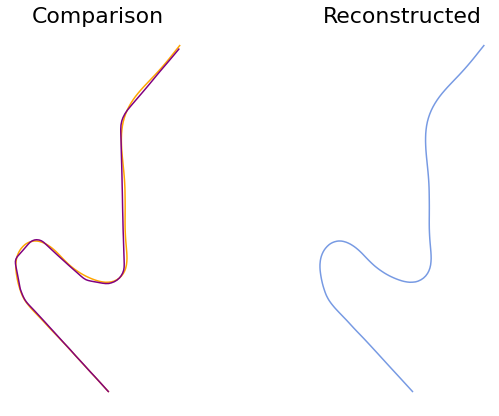

In [9]:
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    traffic[1].plot(ax[0], c="orange", label="reconstructed")
    traffic[0].plot(ax[0], c="purple", label="original")
    ax[1].set_title("Reconstructed")
    traffic[1].plot(ax[1])

    plt.show()

In [10]:
traffic[1].chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [11]:
traffic[0].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [12]:
traffic[1].chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

### Generation

In [13]:
n_samples = 100
p = torch.distributions.Normal(torch.zeros(model.hparams.encoding_dim), 1)
x_sim = p.sample_n(n_samples)
x_sim.size()

torch.Size([100, 32])

In [14]:
encodings = np.concatenate((x, x_sim), axis=0)
encodings.shape

(4068, 32)

In [15]:
z_embedded = TSNE(n_components=2).fit_transform(encodings)
z_embedded.shape

(4068, 2)

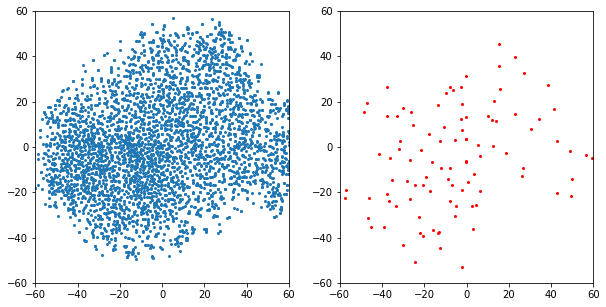

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(z_embedded[:len(dataset), 0], z_embedded[:len(dataset), 1], s=4)
ax[1].scatter(z_embedded[len(dataset):, 0], z_embedded[len(dataset):, 1], s=4, c='red')

for ax_ in ax:
    ax_.set_xlim(-60, 60)
    ax_.set_ylim(-60, 60)

plt.show()

Find closest original trajectories

In [17]:
Xg = x_sim.T
Xr = x.T
print(f"X generated: {Xg.shape}")
print(f"X real: {Xr.shape}")

X generated: torch.Size([32, 100])
X real: (32, 3968)


In [18]:
diff = (Xg[np.newaxis,...] - Xr[np.newaxis,...].T)
D = np.sqrt((diff**2).sum(1)).T
originals_idx = np.argmin(D, axis=1)

In [19]:
originals_idx

tensor([3733,   28,  810, 2821, 3753,  460, 2605, 2456,  815, 1861, 3617, 3661,
        3368, 3322, 1142, 2013,  100, 1219, 3302, 3817, 1839, 2912, 3595,  902,
        1958, 1888, 2889, 1321, 2517, 3154,  568, 1981, 2054, 3658,   63,  736,
        2797,  369, 2809, 3161, 2662,  104, 2668, 2825, 1265, 3947, 1906, 3957,
         910,  101,  607,  316, 2584, 1341, 2064, 3467, 1211, 3531, 1583, 1925,
        1362, 3029, 3411,  333,  886, 1212, 2474, 2690, 1161, 3267,  468,  712,
         256, 3216, 1975,   71, 1012, 1995, 3134,   72, 3488, 2636,  652, 1072,
        1409, 2492,  610, 1015, 3411,  751,  317,    5, 2650, 3490, 2728,  936,
        3775, 1426, 2479,   16])

In [20]:
originals, _, info = dataset[originals_idx]
originals = torch.transpose(originals, 1, 2)
originals.size()

torch.Size([100, 200, 4])

In [21]:
data = originals.detach().numpy()
# data = data.reshape((-1, dataset.input_dim))
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [22]:
# data = data.reshape((10, -1))
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], 200)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_original = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in traffic_original.data.columns:
    traffic_original = traffic_original.cumulative_distance().eval(desc="")

traffic_original

,count
flight_id,
0,200
66,200
75,200
74,200
73,200
72,200
71,200
70,200
7,200


Decode generated samples

In [23]:
outputs = model.decoder(torch.Tensor(x_sim), torch.Tensor([200]*n_samples))
outputs = torch.transpose(outputs, 1, 2)
outputs.size()

torch.Size([100, 200, 4])

In [24]:
data = outputs.detach().numpy()
# data = data.reshape((-1, dataset.input_dim))
data = data.reshape((data.shape[0], -1))
data = dataset.scaler.inverse_transform(data)

In [25]:
# add latitude longitude info
# data = data.reshape((10, -1))
data = np.concatenate((info, data), axis=1)
builder = model.get_builder(data.shape[0], 200)
features = [
    "track" if "track" in f else f for f in model.hparams.features
]
traffic_generated = traffic_from_data(
    data, features, model.dataset_params["info_params"]["features"], builder=builder
)

if "track" not in traffic_generated.data.columns:
    traffic_generated = traffic_generated.cumulative_distance().eval(desc="")

traffic_generated

,count
flight_id,
0,200
66,200
75,200
74,200
73,200
72,200
71,200
70,200
7,200


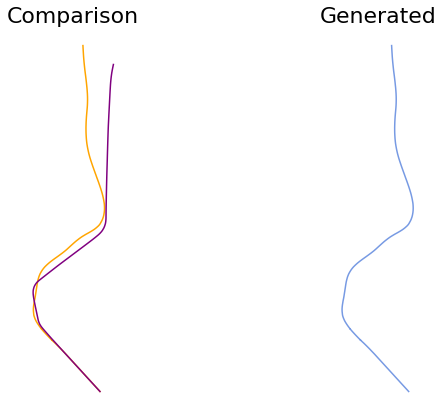

In [26]:
flight_id = 20
generated = traffic_generated[str(flight_id)]
original = traffic_original[str(flight_id)]
    
with plt.style.context("traffic"):
    fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=EuroPP()))
    ax[0].set_title("Comparison")
    generated.plot(ax[0], c="orange", label="generated")
    original.plot(ax[0], c="purple", label="closest original")
    ax[1].set_title("Generated")
    generated.plot(ax[1])

    plt.show()

In [27]:
generated.chart().encode(alt.Y("track"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [28]:
generated.chart().encode(alt.Y("groundspeed"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

In [29]:
generated.chart().encode(alt.Y("altitude"), alt.X("timestamp"), alt.Color("flight_id"))

alt.Chart(...)

Save generated trajectories into csv file

In [30]:
traffic_generated.to_csv("./outputs/vae_gen.csv")

### Douglas-Peucker

In [31]:
simplified_t_gen = (
    traffic_generated
    .simplify(tolerance=1e3)
    .eval(desc="")
)
simplified_t_gen.data

  0%|          | 0/100 [00:00<?, ?it/s]

,track,groundspeed,altitude,timedelta,latitude,longitude,flight_id,callsign,icao24,timestamp
0,201.374603,327.060547,14865.016602,-0.004268,48.079015,8.674146,0,0,0,2021-09-09 09:32:53.995732188+00:00
58,204.854553,244.663788,9705.526367,203.032440,47.819766,8.574155,0,0,0,2021-09-09 09:36:17.032440186+00:00
122,189.731201,191.748245,5320.533203,427.187836,47.659664,8.359322,0,0,0,2021-09-09 09:40:01.187835693+00:00
148,146.624588,207.178741,4297.546387,517.695984,47.581925,8.399839,0,0,0,2021-09-09 09:41:31.695983887+00:00
199,137.111526,134.275711,1595.352905,696.113525,47.483749,8.533772,0,0,0,2021-09-09 09:44:30.113525391+00:00
...,...,...,...,...,...,...,...,...,...,...
19863,207.602112,252.287857,9335.896484,244.428925,47.884809,8.521209,99,99,99,2021-09-09 09:36:58.428924561+00:00
19878,197.536209,242.793167,8462.772461,303.621185,47.817810,8.514797,99,99,99,2021-09-09 09:37:57.621185303+00:00
19933,193.904404,187.659317,4868.091309,516.547363,47.639155,8.376049,99,99,99,2021-09-09 09:41:30.547363281+00:00
19950,145.847198,184.035812,3952.525879,583.487183,47.585482,8.397933,99,99,99,2021-09-09 09:42:37.487182617+00:00


In [32]:
simplified_t_gen.to_csv("./outputs/dp_vae_gen.csv")

### Navigational Points

In [33]:
navpoints_t_gen = pd.concat([
    flight
    .compute_navpoints()
    .assign(
        flight_id=str(flight.flight_id),
        latitude_0=flight.data.iloc[0].latitude,
        longitude_0=flight.data.iloc[0].longitude,
        altitude_0=flight.data.iloc[0].altitude,
        track_0=flight.data.iloc[0].track,
        groundspeed_0=flight.data.iloc[0].groundspeed,
    )
    .drop(columns=[
        "altitude",
        "description",
        "frequency",
        "magnetic_variation"
    ])
    for flight in tqdm(traffic_generated)
])
navpoints_t_gen.head()

100%|██████████| 100/100 [01:11<00:00,  1.40it/s]


,start,stop,duration,navaid,distance,shift_mean,shift_meanp,name,type,latitude,longitude,flight_id,latitude_0,longitude_0,altitude_0,track_0,groundspeed_0
0,2021-09-09 09:33:53.451835632+00:00,2021-09-09 09:35:52.133178711+00:00,0 days 00:01:58.681343079,ZH578,21.262602,0.172197,0.192197,ZH578,FIX,47.502694,8.459167,0,48.079015,8.674146,14865.016602,201.374603,327.060547
1,2021-09-09 09:40:46.151519775+00:00,2021-09-09 09:41:24.504364014+00:00,0 days 00:00:38.352844239,ZH578,5.740382,0.017410,0.037410,ZH578,FIX,47.502694,8.459167,0,48.079015,8.674146,14865.016602,201.374603,327.060547
2,2021-09-09 09:36:31.103683472+00:00,2021-09-09 09:37:27.440216064+00:00,0 days 00:00:56.336532592,ZH109,4.435269,0.032537,0.052537,ZH109,FIX,47.694778,8.446194,0,48.079015,8.674146,14865.016602,201.374603,327.060547
3,2021-09-09 09:37:47.621551514+00:00,2021-09-09 09:39:07.933685303+00:00,0 days 00:01:20.312133789,ZH065,6.883690,0.043262,0.063262,ZH065,FIX,47.616278,8.275611,0,48.079015,8.674146,14865.016602,201.374603,327.060547
4,2021-09-09 09:41:49.701782227+00:00,2021-09-09 09:44:05.994201660+00:00,0 days 00:02:16.292419433,D337B,0.531890,0.018739,0.038739,D337B,FIX,47.488086,8.527586,0,48.079015,8.674146,14865.016602,201.374603,327.060547


In [34]:
navpoints_t_gen.to_csv("./outputs/nav_vae_gen.csv")